In [21]:
import sys
sys.path.append('..')

import pathlib
import numpy as np
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from skimage.filters import sobel
from skimage.color import rgb2gray
from utils import transform_and_store, plot_transformation_comparison, plot_features
import gc

main_path='../dados/Hypercellularity/'

# Roteiro I - Local Binary Pattern

In [23]:
def apply_lbp(input_image):
    if len(input_image.shape) > 2:
        input_image = rgb2gray(input_image)
    radius = 3
    n_points = 8 * radius
    return local_binary_pattern(input_image, n_points, radius)

folders = ['03-equalizesHist','04-gammaCorrection','05-gammaCorrection02',
            '06-gammaCorrection03','07-gaussianFilter','09-laplaceFilterFromGray']

for i, folder in enumerate(folders):
    transform_and_store(
        main_path=main_path,
        data_folder_name=folder, 
        new_folder_name=f'10.{i}-LBP_from_{folder}', 
        transformation_function=apply_lbp,
        output_type='nparray'
        )

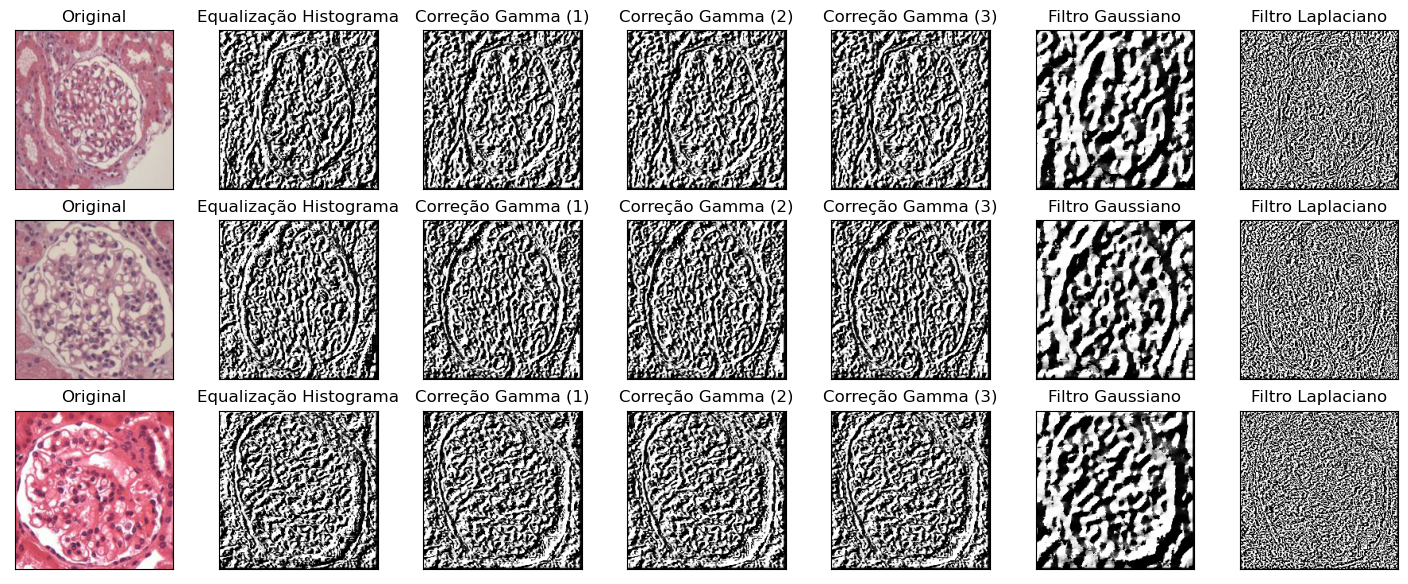

In [24]:
folders = ['01-resized','10.0-LBP_from_03-equalizesHist','10.1-LBP_from_04-gammaCorrection','10.2-LBP_from_05-gammaCorrection02',
            '10.3-LBP_from_06-gammaCorrection03','10.4-LBP_from_07-gaussianFilter','10.5-LBP_from_09-laplaceFilterFromGray']

titles = ['Original', 'Equalização Histograma', 'Correção Gamma (1)', 'Correção Gamma (2)', 'Correção Gamma (3)', 'Filtro Gaussiano',
            'Filtro Laplaciano' ]

plot_features(main_path, folders, titles)

# Roteiro II - Haralick GLCM

In [25]:
def apply_haralick_features(input_image, patch_size=25):
    if len(input_image.shape) > 2:
        input_image = input_image[:,:,0]
    """Return a map of Haralick features (one feature vector per pixel)"""
    distance = [1]
    angles = [0]
    properties = ['correlation', 'homogeneity', 'contrast', 'energy', 'dissimilarity']

    texture_features = []
    for i in range(0, input_image.shape[0], patch_size):
        for j in range(0, input_image.shape[1], patch_size):
            block = input_image[i:i+patch_size, j:j+patch_size]

            glcm_mat = graycomatrix(block, distances=distance, angles=angles, levels=256, symmetric=True, normed=True)
            block_glcm = np.hstack([graycoprops(glcm_mat, props).ravel() for props in properties])
            texture_features.append(block_glcm)

    return np.concatenate(texture_features)

folders = ['03-equalizesHist','04-gammaCorrection','05-gammaCorrection02',
            '06-gammaCorrection03','07-gaussianFilter','09-laplaceFilterFromGray']

for i, folder in enumerate(folders):
    transform_and_store(
        main_path=main_path,
        data_folder_name=folder, 
        new_folder_name=f'11.{i}-GLCM_from_{folder}', 
        transformation_function=apply_haralick_features,
        output_type='nparray'
        )

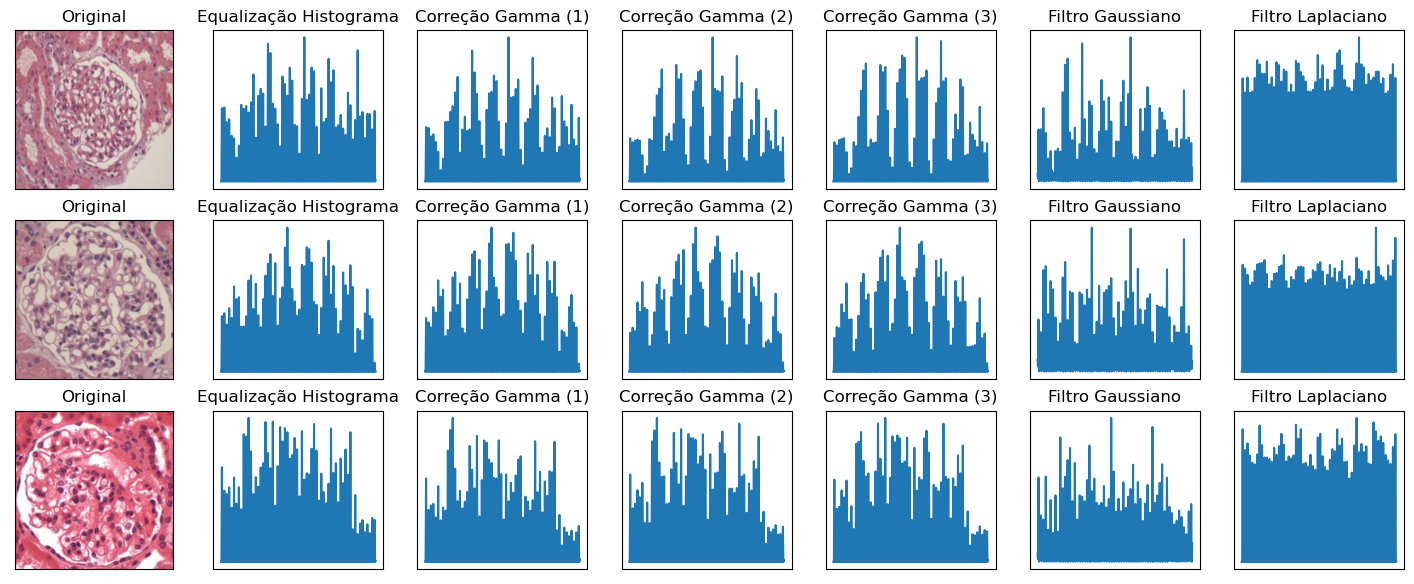

In [26]:
folders = ['01-resized','11.0-GLCM_from_03-equalizesHist','11.1-GLCM_from_04-gammaCorrection','11.2-GLCM_from_05-gammaCorrection02',
            '11.3-GLCM_from_06-gammaCorrection03','11.4-GLCM_from_07-gaussianFilter','11.5-GLCM_from_09-laplaceFilterFromGray']

titles = ['Original', 'Equalização Histograma', 'Correção Gamma (1)', 'Correção Gamma (2)', 'Correção Gamma (3)', 'Filtro Gaussiano',
            'Filtro Laplaciano' ]

plot_features(main_path, folders, titles, result_is_image=False)

# Roteiro III - Sobel

In [27]:
def apply_sobel(input_image):
    return sobel(input_image)

folders = ['03-equalizesHist','04-gammaCorrection','05-gammaCorrection02',
            '06-gammaCorrection03','07-gaussianFilter','09-laplaceFilterFromGray']

for i, folder in enumerate(folders):
    transform_and_store(
        main_path=main_path,
        data_folder_name=folder, 
        new_folder_name=f'12.{i}-sobel_from_{folder}', 
        transformation_function=apply_sobel,
        output_type='nparray'
        )

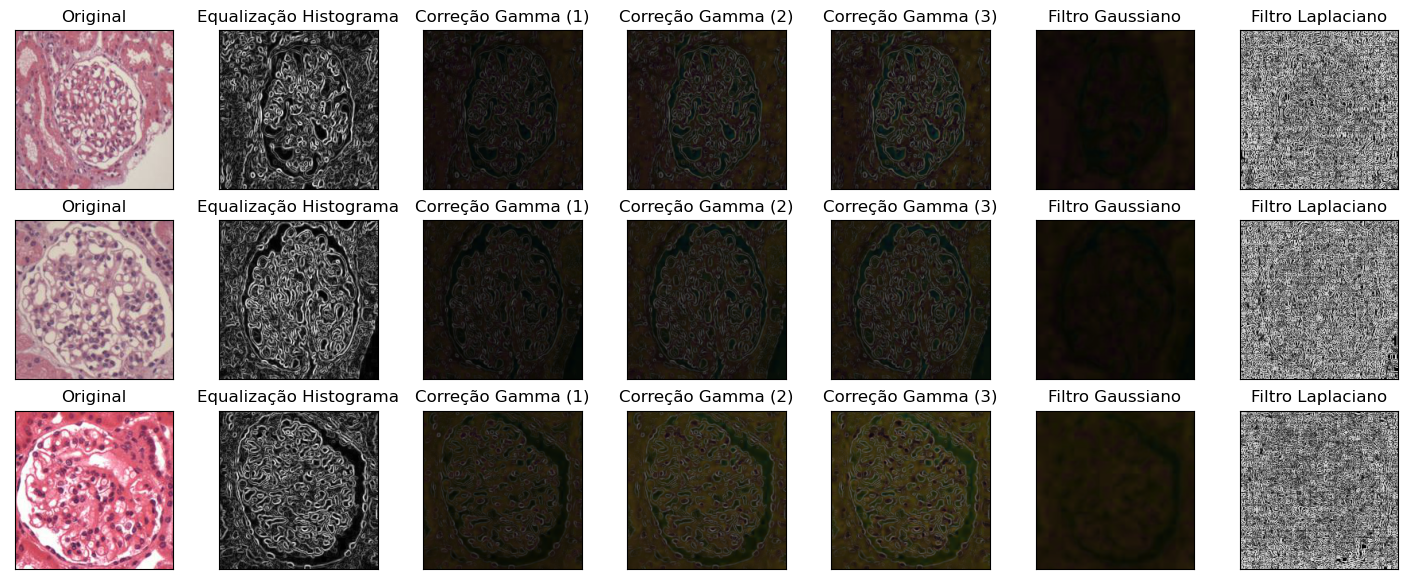

In [28]:
folders = ['01-resized','12.0-sobel_from_03-equalizesHist','12.1-sobel_from_04-gammaCorrection','12.2-sobel_from_05-gammaCorrection02',
            '12.3-sobel_from_06-gammaCorrection03','12.4-sobel_from_07-gaussianFilter','12.5-sobel_from_09-laplaceFilterFromGray']

titles = ['Original', 'Equalização Histograma', 'Correção Gamma (1)', 'Correção Gamma (2)', 'Correção Gamma (3)', 'Filtro Gaussiano',
            'Filtro Laplaciano' ]

plot_features(main_path, folders, titles)

In [38]:
def concat_features(subfolder, image_code):
    main_path='../dados/Hypercellularity/'
    data_path = pathlib.Path(main_path)
    features = []
    for steps in ['10','11','12']:
        for path in data_path.glob(f'**/{steps}.*'):
            image_feature = np.load(str(path) + f'/{subfolder}/{image_code}.npy')
            if len(image_feature.shape) == 3:
                image_feature = image_feature[:,:,0].flatten()
                features.append(image_feature.copy())
            elif len(image_feature.shape) == 2:
                image_feature = image_feature.flatten()
                features.append(image_feature.copy())
            else:
                features.append(image_feature.copy())

            del image_feature
            gc.collect()

    return np.concatenate(features)

def normalize(xs):
    v_min = xs.min(axis=(0), keepdims=True)
    v_max = xs.max(axis=(0), keepdims=True)
    xs = (xs - v_min)/(v_max - v_min)
    return xs


def agregate_features():

    original_path = '../dados/Hypercellularity/00-original/'

    features = []
    labels = []

    SUB_FOLDERS = ['n', 'p']
    for sub_folder in SUB_FOLDERS:
        data_path = pathlib.Path(original_path + sub_folder)
        for path in data_path.glob('*'):
            image_code = str(path)[:-4].replace(str(data_path)+'/', "")
            image_representation = concat_features(sub_folder, image_code)
            image_representation = normalize(image_representation)
            image_class = 1 if sub_folder == 'n' else -1
            features.append(image_representation)
            labels.append(image_class)

    x = np.vstack(features) 
    y = np.vstack(labels) 

    return x, y
      

In [39]:
x, y = agregate_features()

In [40]:
saving_path = pathlib.Path(main_path +'/13.0-final_dataset_200x200')

saving_path.mkdir(parents=True, exist_ok=True)

np.save(str(saving_path)+ '/x', x)
np.save(str(saving_path)+ '/y', y)

: 